<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
!pip install pyomo
from pyomo.environ import *
from pyomo import environ as pe
import random
#!get -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
#!unzip -o -q ipopt-linux64
#solver= SolverFactory('ipopt', executable='/content/ipopt')
import numpy as np

import pyomo.environ as pyo
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#!apt-get install -y -qq coinor-cbc
#solver= SolverFactory('cbc', executable='/usr/bin/cbc')
!apt-get install -y -qq glpk-utils
opt = SolverFactory('glpk', executable='/usr/bin/glpsol')


!pip install highspy
opt = pe.SolverFactory("appsi_highs")


Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 126435 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

In [ ]:
import numpy
from numpy.random import randint as rand

def generate_maze(width=51, height=30, complexity=.866, density=.9):
    """Generate a maze using a maze generation algorithm."""
    # Only odd shapes
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
    # Adjust complexity and density relative to maze size
    complexity = int(complexity * (5 * (shape[0] + shape[1])))  # Number of components
    density    = int(density * ((shape[0] // 2) * (shape[1] // 2)))  # Size of components
    # Build actual maze
    Z = numpy.zeros(shape, dtype=bool)
    # Fill borders
    Z[0, :] = Z[-1, :] = 1
    Z[:, 0] = Z[:, -1] = 1
    # Make aisles
    for i in range(density):
        x, y = rand(0, shape[1] // 2) * 2, rand(0, shape[0] // 2) * 2  # Pick a random position
        Z[y, x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1:             neighbours.append((y, x - 2))
            if x < shape[1] - 2:  neighbours.append((y, x + 2))
            if y > 1:             neighbours.append((y - 2, x))
            if y < shape[0] - 2:  neighbours.append((y + 2, x))
            if len(neighbours):
                y_, x_ = neighbours[rand(0, len(neighbours) - 1)]
                if Z[y_, x_] == 0:
                    Z[y_, x_] = 1
                    Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_
    return Z

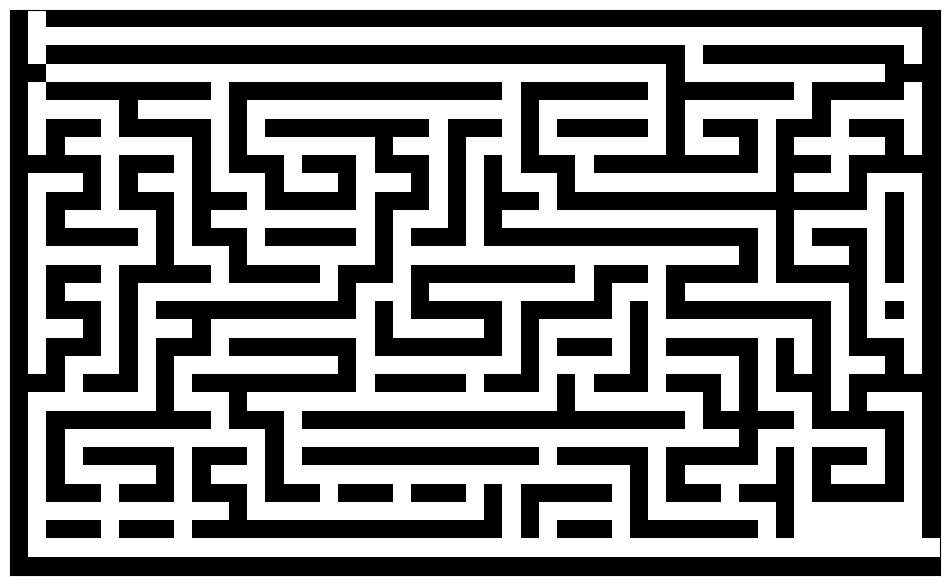

In [ ]:
maze=generate_maze()

#maze[12,79] = True
#maze[30,79] = True
#maze[60,79] = True

#maze[12,1] = True
#maze[30,1] = True

out_cord = [maze.shape[0]-2,maze.shape[1]-1]

maze[out_cord[0],out_cord[1]] = False
maze[0,1] = False

plt.figure(figsize=(12, 8))

for r in [1,maze.shape[1]-2]:
  for c in [3 , 8  ,20]:
    maze[c,r] = True


    #plt.scatter(r,c,s=10 , c='r')
plt.imshow(maze, cmap=plt.cm.binary, interpolation='nearest')
plt.xticks([]), plt.yticks([])
plt.show()


In [ ]:
data = {}
source = [0]
node_counter = 0
for r in range(maze.shape[0]):
  for c in range(maze.shape[1]):
    if not maze[r,c]:
      data[node_counter] = {'x':c,'y':r}
      if out_cord== [r,c]:
        sink = [node_counter]
      node_counter += 1

nodes = [n for n in range(node_counter)]

connect = list(set([(i,j) for i in nodes for j in nodes if abs(data[i]['x']-data[j]['x']) + abs(data[i]['y']-data[j]['y']) == 1 ]))

cost = {(i,j): random.randint(1,5) for (i,j) in connect}

print(node_counter, len(nodes) , len(connect))

783 783 1638


In [ ]:
model = AbstractModel()

# Sets
model.n = Set(initialize=nodes)
model.flow_set = Set(dimen=2, initialize=connect)
model.flow = Var(model.flow_set, bounds=(0,1) , within= NonNegativeReals)
model.cost_values = Param(model.flow_set, initialize=cost, mutable= True)
def source_sink(model, n):
  expr = sum(model.flow[(n,j)]-model.flow[(j,n)] for j in model.n if (n,j) in model.flow_set)
  if n in source:
    return 1-0 == expr
  elif n in sink:
    return 0-1 == expr
  else:
    return 0 == expr
model.C1 = Constraint(model.n, rule=source_sink)

def obj_rule(model):
  return sum(model.cost_values[i,j]*model.flow[(i,j)] for i in model.n for j in model.n if (i,j) in model.flow_set)
model.obj = Objective(rule=obj_rule, sense = minimize)

instance = model.create_instance()
results = opt.solve(instance)


# Display results
print("Solver Status:", results.solver.status)
print("Termination Condition:", results.solver.termination_condition)



Solver Status: ok
Termination Condition: optimal


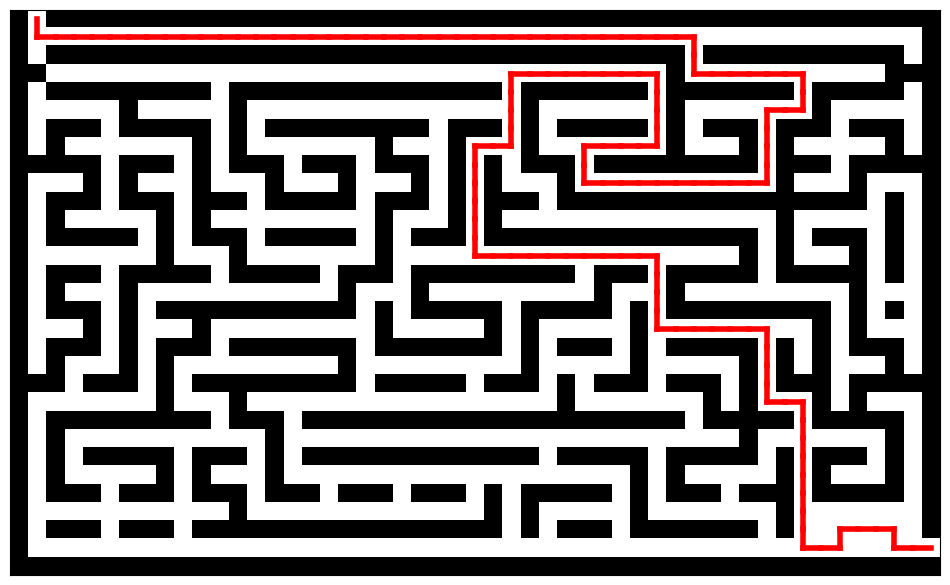

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(maze, cmap=plt.cm.binary, interpolation='nearest')
plt.xticks([]), plt.yticks([])

for (i,j) in instance.flow:
  if value(instance.flow[i,j]):
    x1,y1 = data[i]['x'],data[i]['y']
    x2,y2 = data[j]['x'],data[j]['y']
    plt.plot([x1,x2],[y1,y2], c= 'r', lw=4)
plt.show()

In [ ]:
!pip install ortools
from ortools.sat.python import cp_model
import time


model = cp_model.CpModel()
x={(i,j):model.NewBoolVar(f"flow_{i}_{j}") for (i,j) in connect}
assign = {i: model.NewBoolVar(f"assign_{i}") for i in nodes}


endpoint = {i: model.NewBoolVar(f"end_{i}") for i in nodes }
startpoint = {i: model.NewBoolVar(f"st_{i}") for i in sink+source }

linked= {(i,j): model.NewBoolVar(f"linked_{i}_{j}") for i in endpoint for j in startpoint if i<j and (i,j) not in connect}
print('ckeck' , len(linked) )
###################################################################################################
arcs= [ (i,j,v) for (i,j),v in x.items()] + [(i,i,assign[i].Not()) for i in nodes] + [(i,j,v) for (i,j),v in linked.items()]
model.AddCircuit(arcs)

for n in nodes:
  if n in startpoint:
    model.AddAtMostOne([startpoint[n] , endpoint[n]])
    model.Add(startpoint[n] <= assign[n])
    model.Add(endpoint[n] <= assign[n])


  expr_out = [x[n,j] for j in nodes if (n,j) in connect] + [linked[n,j] for j in startpoint if (n,j) in linked]
  model.Add(cp_model.LinearExpr.Sum(expr_out) == assign[n] )


  expr_in = [x[j,n] for j in nodes if (j,n) in connect] + [linked[j,n] for j in endpoint if (j,n) in linked]
  model.Add(cp_model.LinearExpr.Sum(expr_in) == assign[n] )
  X_expr_in = [x[j,n] for j in nodes if (j,n) in connect]
  X_expr_out = [x[n,j] for j in nodes if (n,j) in connect]


  #model.Add(cp_model.LinearExpr.Sum(X_expr_in) == assign[n] ).OnlyEnforceIf(startpoint[n].Not())
  #model.Add(cp_model.LinearExpr.Sum(X_expr_out) == assign[n] ).OnlyEnforceIf(endpoint[n].Not())

expr_st = [v for n,v in startpoint.items() ]
model.AddExactlyOne(expr_st)
expr_fn = [v for n,v in endpoint.items() ]
model.AddExactlyOne(expr_fn)
expr_lnk =  [v for (i,j),v in linked.items()]
model.AddExactlyOne(expr_lnk)

expr_final = [v*n for n,v in endpoint.items()]
expr_start = [v*n for n,v in startpoint.items()]
model.Add(cp_model.LinearExpr.Sum(expr_final) < cp_model.LinearExpr.Sum(expr_start))

for (i,j),v in linked.items():
  model.Add(v <= assign[i])
  model.Add(v <= assign[j])
  model.Add(v <= startpoint[j])
  model.Add(v <= endpoint[i])
  model.Add(v >= startpoint[j] +endpoint[i] -1)

for n in nodes:
  to_n = [j for j in nodes if (n,j) in connect]
  if len(to_n) ==1 and n in startpoint:
    j_connected =to_n[0]
    model.Add(assign[n] == startpoint[n]+endpoint[n])
    model.Add(assign[j_connected]  >= assign[n])
  elif len(to_n) ==2:
    model.Add(2*assign[n] <= cp_model.LinearExpr.Sum([assign[j] for j in to_n]) )

expressions_of = [v for v in assign.values()]
model.Maximize(cp_model.LinearExpr.Sum(expressions_of))

solver = cp_model.CpSolver()
solver.parameters.num_workers = 32
#solver.parameters.subsolvers[:] = ['core','pseudo_costs','quick_restart_no_lp','default_lp']
solver.parameters.max_time_in_seconds = 120

status = solver.solve(model)
print(solver.StatusName(status))

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
  pass
else:
  print("No solution found.")

print(f"Min of objective function: {solver.objective_value}\n")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.31.1 w

ckeck 781
OPTIMAL
Min of objective function: 455.0



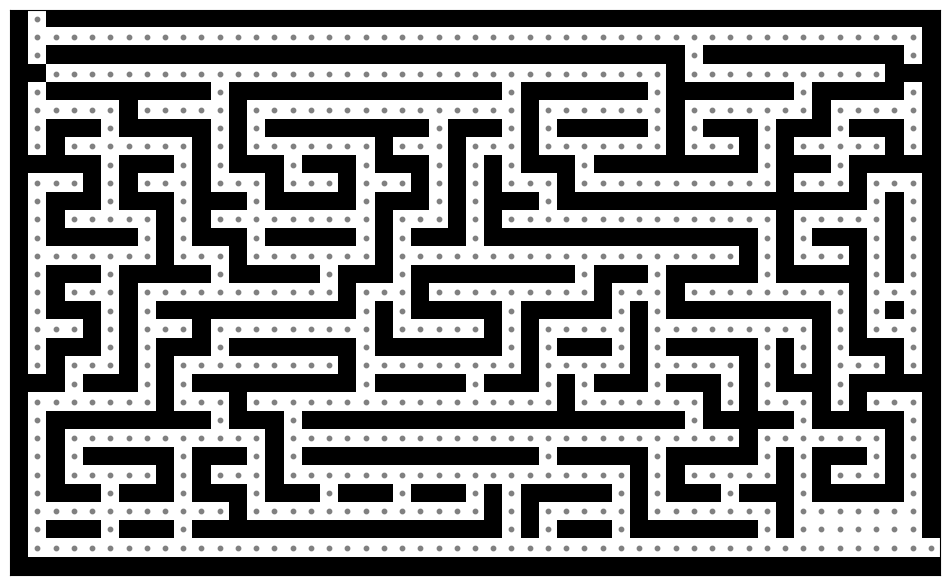

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(maze, cmap=plt.cm.binary, interpolation='nearest')
plt.xticks([]), plt.yticks([])
for i in nodes:
  x1,y1 = data[i]['x'],data[i]['y']
  plt.scatter(x1,y1, s=10 , c='grey')

Linked 0 782
1 1


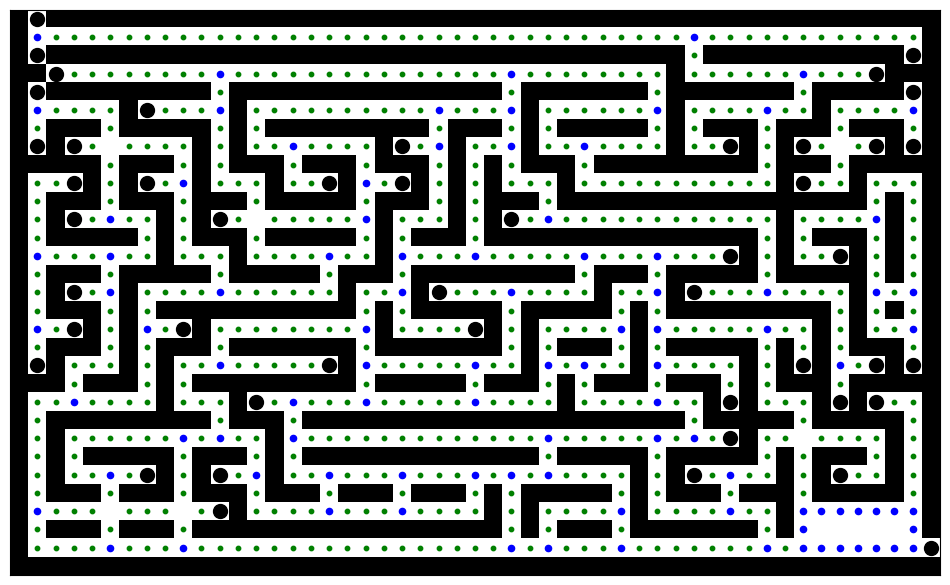

end 0
start 782


In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(maze, cmap=plt.cm.binary, interpolation='nearest')
plt.xticks([]), plt.yticks([])

for (i,j) in x:
  if solver.value(x[i,j]):

    x1,y1 = data[i]['x'],data[i]['y']
    x2,y2 = data[j]['x'],data[j]['y']
    #plt.plot([x1,x2],[y1,y2], c= 'r', lw=4)
    #print(f"from{i} to {j}")
    #plt.text(x1,y1, s=str(i), fontsize=6)
    #plt.text(x2,y2, s=str(j), fontsize=6)
for (i,j),v in linked.items():
  if solver.value(v):
    x1,y1 = data[i]['x'],data[i]['y']
    x2,y2 = data[j]['x'],data[j]['y']
    #plt.plot([x1,x2],[y1,y2], c= 'b', lw=4)
    #plt.text(x1,y1, s=str(i))
    #plt.text(x2,y2, s=str(j))
    print('Linked', i,j)
    print(solver.value(startpoint[j]), solver.value(endpoint[i]))


for n in nodes:
  to_n = [j for j in nodes if (n,j) in connect]
  if len(to_n) ==1:
    x1,y1 = data[n]['x'],data[n]['y']
    plt.scatter(x1,y1, s=100 , c='k')
  elif len(to_n) ==2:
    x1,y1 = data[n]['x'],data[n]['y']
    plt.scatter(x1,y1, s=10 , c='g')
  elif len(to_n) ==3:
    x1,y1 = data[n]['x'],data[n]['y']
    plt.scatter(x1,y1, s=20 , c='b')

plt.show()

for n in nodes:
  if solver.value(startpoint.get(n,0))>0:
    print(f"start {n}")
  if solver.value(endpoint[n])>0:
    print(f"end {n}")